## Primetrade.ai --> Task


#### Problem Statement / Objective

You need to analyze historical trade data from various Binance accounts over 90 days and evaluate their performance based on multiple financial metrics. The goal is to rank the accounts based on these metrics and identify the top 20 best-performing accounts.

Key Tasks:

1. Data Cleaning & Exploration:

- Load and inspect the dataset.
- Handle missing or inconsistent values.
- Understand the trade structure (e.g., Port_ID, timestamp, side, price, quantity, etc.).

2. Feature Engineering & Metrics Calculation:

Calculate financial performance metrics for each account, including:

- ROI (Return on Investment)
- PnL (Profit and Loss)
- Sharpe Ratio (Risk-adjusted returns)
- MDD (Maximum Drawdown) (Biggest loss from peak)
- Win Rate (% of profitable trades)
- Win Positions (Number of profitable trades)
- Total Positions (Total number of trades)

3. Ranking Algorithm:

- Develop a scoring system based on the calculated metrics.
- Assign weights to different metrics to determine overall ranking.
- Identify the top 20 accounts based on performance.

4. Documentation & Report:

- Explain methodology, assumptions, and findings in a structured report.
- Provide a final ranked list of the top 20 accounts.


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
df = pd.read_csv("D:\\Assignment\\Assinment\\TRADES_CopyTr_90D_ROI.csv")

In [78]:
df.head()

,Port_IDs,Trade_History
0,3925368433214965504,"[{'time': 1718899656000, 'symbol': 'SOLUSDT', ..."
1,4002413037164645377,"[{'time': 1718980078000, 'symbol': 'NEARUSDT',..."
2,3923766029921022977,"[{'time': 1718677164000, 'symbol': 'ETHUSDT', ..."
3,3994879592543698688,"[{'time': 1718678214000, 'symbol': 'ETHUSDT', ..."
4,3926423286576838657,"[{'time': 1718979615000, 'symbol': 'ETHUSDT', ..."


In [79]:
df.shape

(150, 2)

In [80]:
df.isnull().sum()

Port_IDs         0
Trade_History    1
dtype: int64

In [81]:
df["Trade_History"].isnull().sum()

1

In [82]:
df.head()

,Port_IDs,Trade_History
0,3925368433214965504,"[{'time': 1718899656000, 'symbol': 'SOLUSDT', ..."
1,4002413037164645377,"[{'time': 1718980078000, 'symbol': 'NEARUSDT',..."
2,3923766029921022977,"[{'time': 1718677164000, 'symbol': 'ETHUSDT', ..."
3,3994879592543698688,"[{'time': 1718678214000, 'symbol': 'ETHUSDT', ..."
4,3926423286576838657,"[{'time': 1718979615000, 'symbol': 'ETHUSDT', ..."


In [83]:
df["Trade_History"].head()

0    [{'time': 1718899656000, 'symbol': 'SOLUSDT', ...
1    [{'time': 1718980078000, 'symbol': 'NEARUSDT',...
2    [{'time': 1718677164000, 'symbol': 'ETHUSDT', ...
3    [{'time': 1718678214000, 'symbol': 'ETHUSDT', ...
4    [{'time': 1718979615000, 'symbol': 'ETHUSDT', ...
Name: Trade_History, dtype: object

In [84]:
type(df["Trade_History"].iloc[0])

str

In [85]:
import ast  # Built-in library to safely evaluate strings containing Python expressions

In [86]:
# Function to safely parse JSON-like strings
def safe_json_loads(x):
    try:
        if pd.isna(x) or x.strip() == "":
            return None  # Handle empty values
        return eval(x)  # Convert string to a Python list safely
    except Exception as e:
        print(f"Error parsing JSON: {e}")
        return None  # Handle errors

In [87]:
# Convert the column from string to list of dictionaries
df["Trade_History"] = df["Trade_History"].apply(safe_json_loads)

In [88]:
# Drop rows where JSON parsing failed
df = df.dropna(subset=["Trade_History"])

In [89]:
# Explode the list of dictionaries into separate rows
df_exploded = df.explode("Trade_History").reset_index(drop=True)

In [90]:
# Convert the dictionary to separate columns
df_trades = pd.json_normalize(df_exploded["Trade_History"])

In [91]:
#  Combine the "Port_IDs" with trades details
df_final = pd.concat([df_exploded[["Port_IDs"]], df_trades], axis=1)

In [92]:
# Convert time from milliseconds to datetime
df_final["time"] = pd.to_datetime(df_final["time"], unit="ms")

In [93]:
df_final.head()

,Port_IDs,time,symbol,side,price,fee,feeAsset,quantity,quantityAsset,realizedProfit,realizedProfitAsset,baseAsset,qty,positionSide,activeBuy
0,3925368433214965504,2024-06-20 16:07:36,SOLUSDT,BUY,132.53700,-0.994027,USDT,1988.05500,USDT,0.0,USDT,SOL,15.0,LONG,True
1,3925368433214965504,2024-06-20 16:06:58,DOGEUSDT,BUY,0.12182,-0.279796,USDT,1398.98088,USDT,0.0,USDT,DOGE,11484.0,LONG,False
2,3925368433214965504,2024-06-20 16:06:58,DOGEUSDT,BUY,0.12182,-0.039494,USDT,197.47022,USDT,0.0,USDT,DOGE,1621.0,LONG,False
3,3925368433214965504,2024-06-20 16:06:56,DOGEUSDT,BUY,0.12182,-0.008284,USDT,16.56752,USDT,0.0,USDT,DOGE,136.0,LONG,True
4,3925368433214965504,2024-06-20 16:06:56,DOGEUSDT,BUY,0.12182,-0.046109,USDT,92.21774,USDT,0.0,USDT,DOGE,757.0,LONG,True


In [94]:
df_final.shape

(211277, 15)

C:\Users\ANAS KHAN\AppData\Local\Temp\ipykernel_17212\1173157886.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_trades, x="side", palette="coolwarm", ax=axes[0, 1])


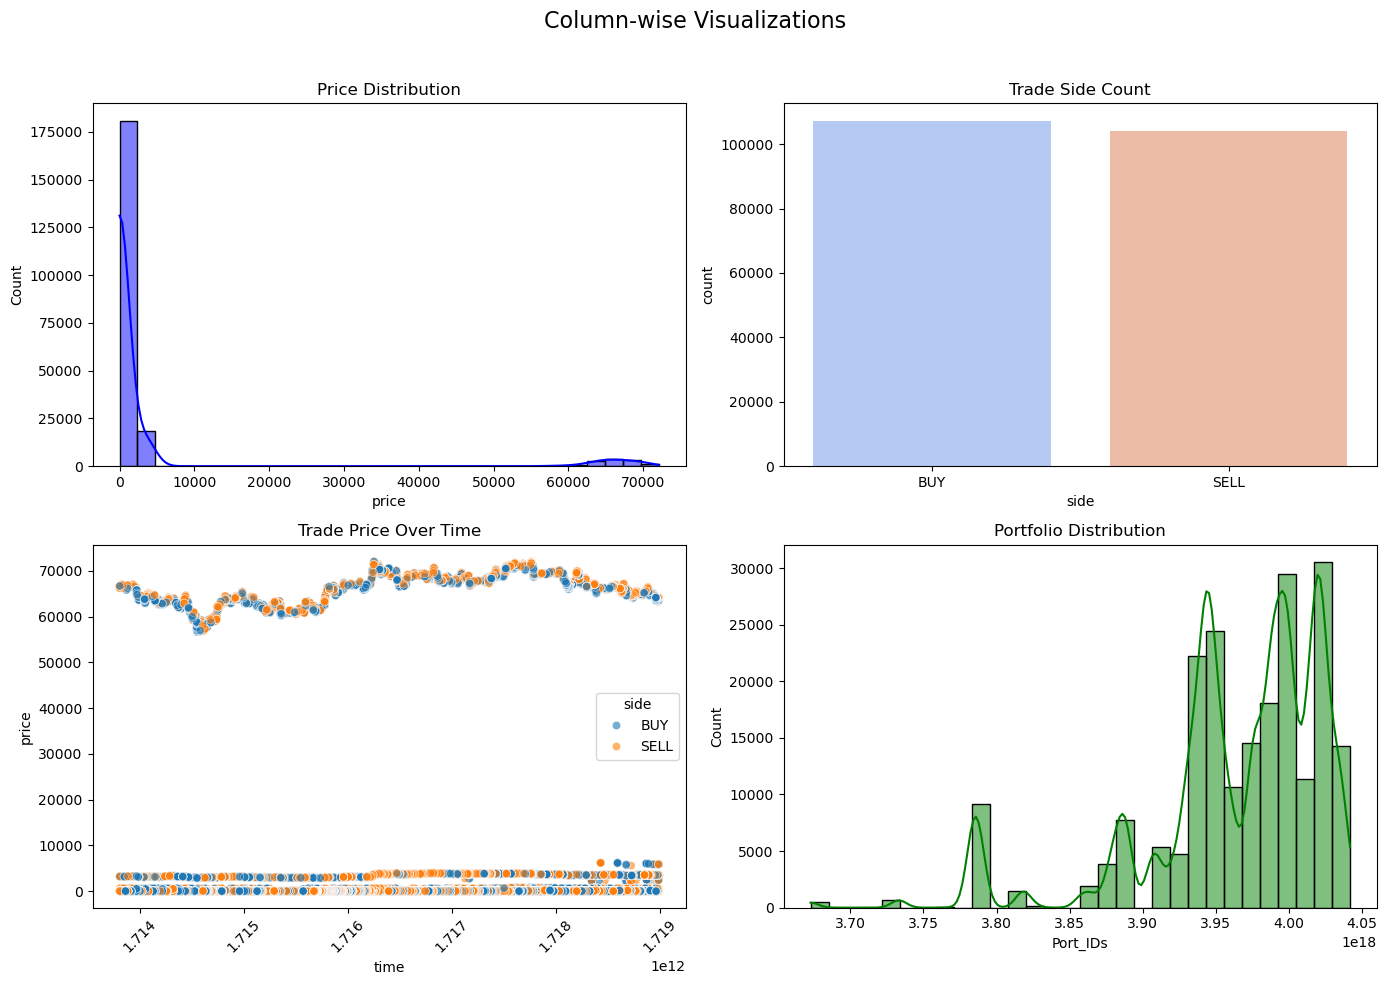

In [95]:
import matplotlib.pyplot as plt

# Set figure size for multiple plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle("Column-wise Visualizations", fontsize=16)

# Histogram for Price Distribution
sns.histplot(df_trades["price"], bins=30, kde=True, ax=axes[0, 0], color="blue")
axes[0, 0].set_title("Price Distribution")

# Count plot for Trade Side (BUY/SELL)
sns.countplot(data=df_trades, x="side", palette="coolwarm", ax=axes[0, 1])
axes[0, 1].set_title("Trade Side Count")

# Scatter plot for Time vs Price
sns.scatterplot(
    data=df_trades, x="time", y="price", hue="side", alpha=0.6, ax=axes[1, 0]
)
axes[1, 0].set_title("Trade Price Over Time")
axes[1, 0].tick_params(axis="x", rotation=45)

# Count plot for Portfolios
sns.histplot(df_final["Port_IDs"], bins=30, kde=True, ax=axes[1, 1], color="green")
axes[1, 1].set_title("Portfolio Distribution")

# Adjust layout for better visibility
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plots
plt.show()

In [96]:
df_final["Port_IDs"].nunique()

149

In [97]:
# check for missing values
df_final.isnull().sum()

Port_IDs               0
time                   0
symbol                 0
side                   0
price                  0
fee                    0
feeAsset               0
quantity               0
quantityAsset          0
realizedProfit         0
realizedProfitAsset    0
baseAsset              0
qty                    0
positionSide           0
activeBuy              0
dtype: int64

In [98]:
df_final.head()

,Port_IDs,time,symbol,side,price,fee,feeAsset,quantity,quantityAsset,realizedProfit,realizedProfitAsset,baseAsset,qty,positionSide,activeBuy
0,3925368433214965504,2024-06-20 16:07:36,SOLUSDT,BUY,132.53700,-0.994027,USDT,1988.05500,USDT,0.0,USDT,SOL,15.0,LONG,True
1,3925368433214965504,2024-06-20 16:06:58,DOGEUSDT,BUY,0.12182,-0.279796,USDT,1398.98088,USDT,0.0,USDT,DOGE,11484.0,LONG,False
2,3925368433214965504,2024-06-20 16:06:58,DOGEUSDT,BUY,0.12182,-0.039494,USDT,197.47022,USDT,0.0,USDT,DOGE,1621.0,LONG,False
3,3925368433214965504,2024-06-20 16:06:56,DOGEUSDT,BUY,0.12182,-0.008284,USDT,16.56752,USDT,0.0,USDT,DOGE,136.0,LONG,True
4,3925368433214965504,2024-06-20 16:06:56,DOGEUSDT,BUY,0.12182,-0.046109,USDT,92.21774,USDT,0.0,USDT,DOGE,757.0,LONG,True


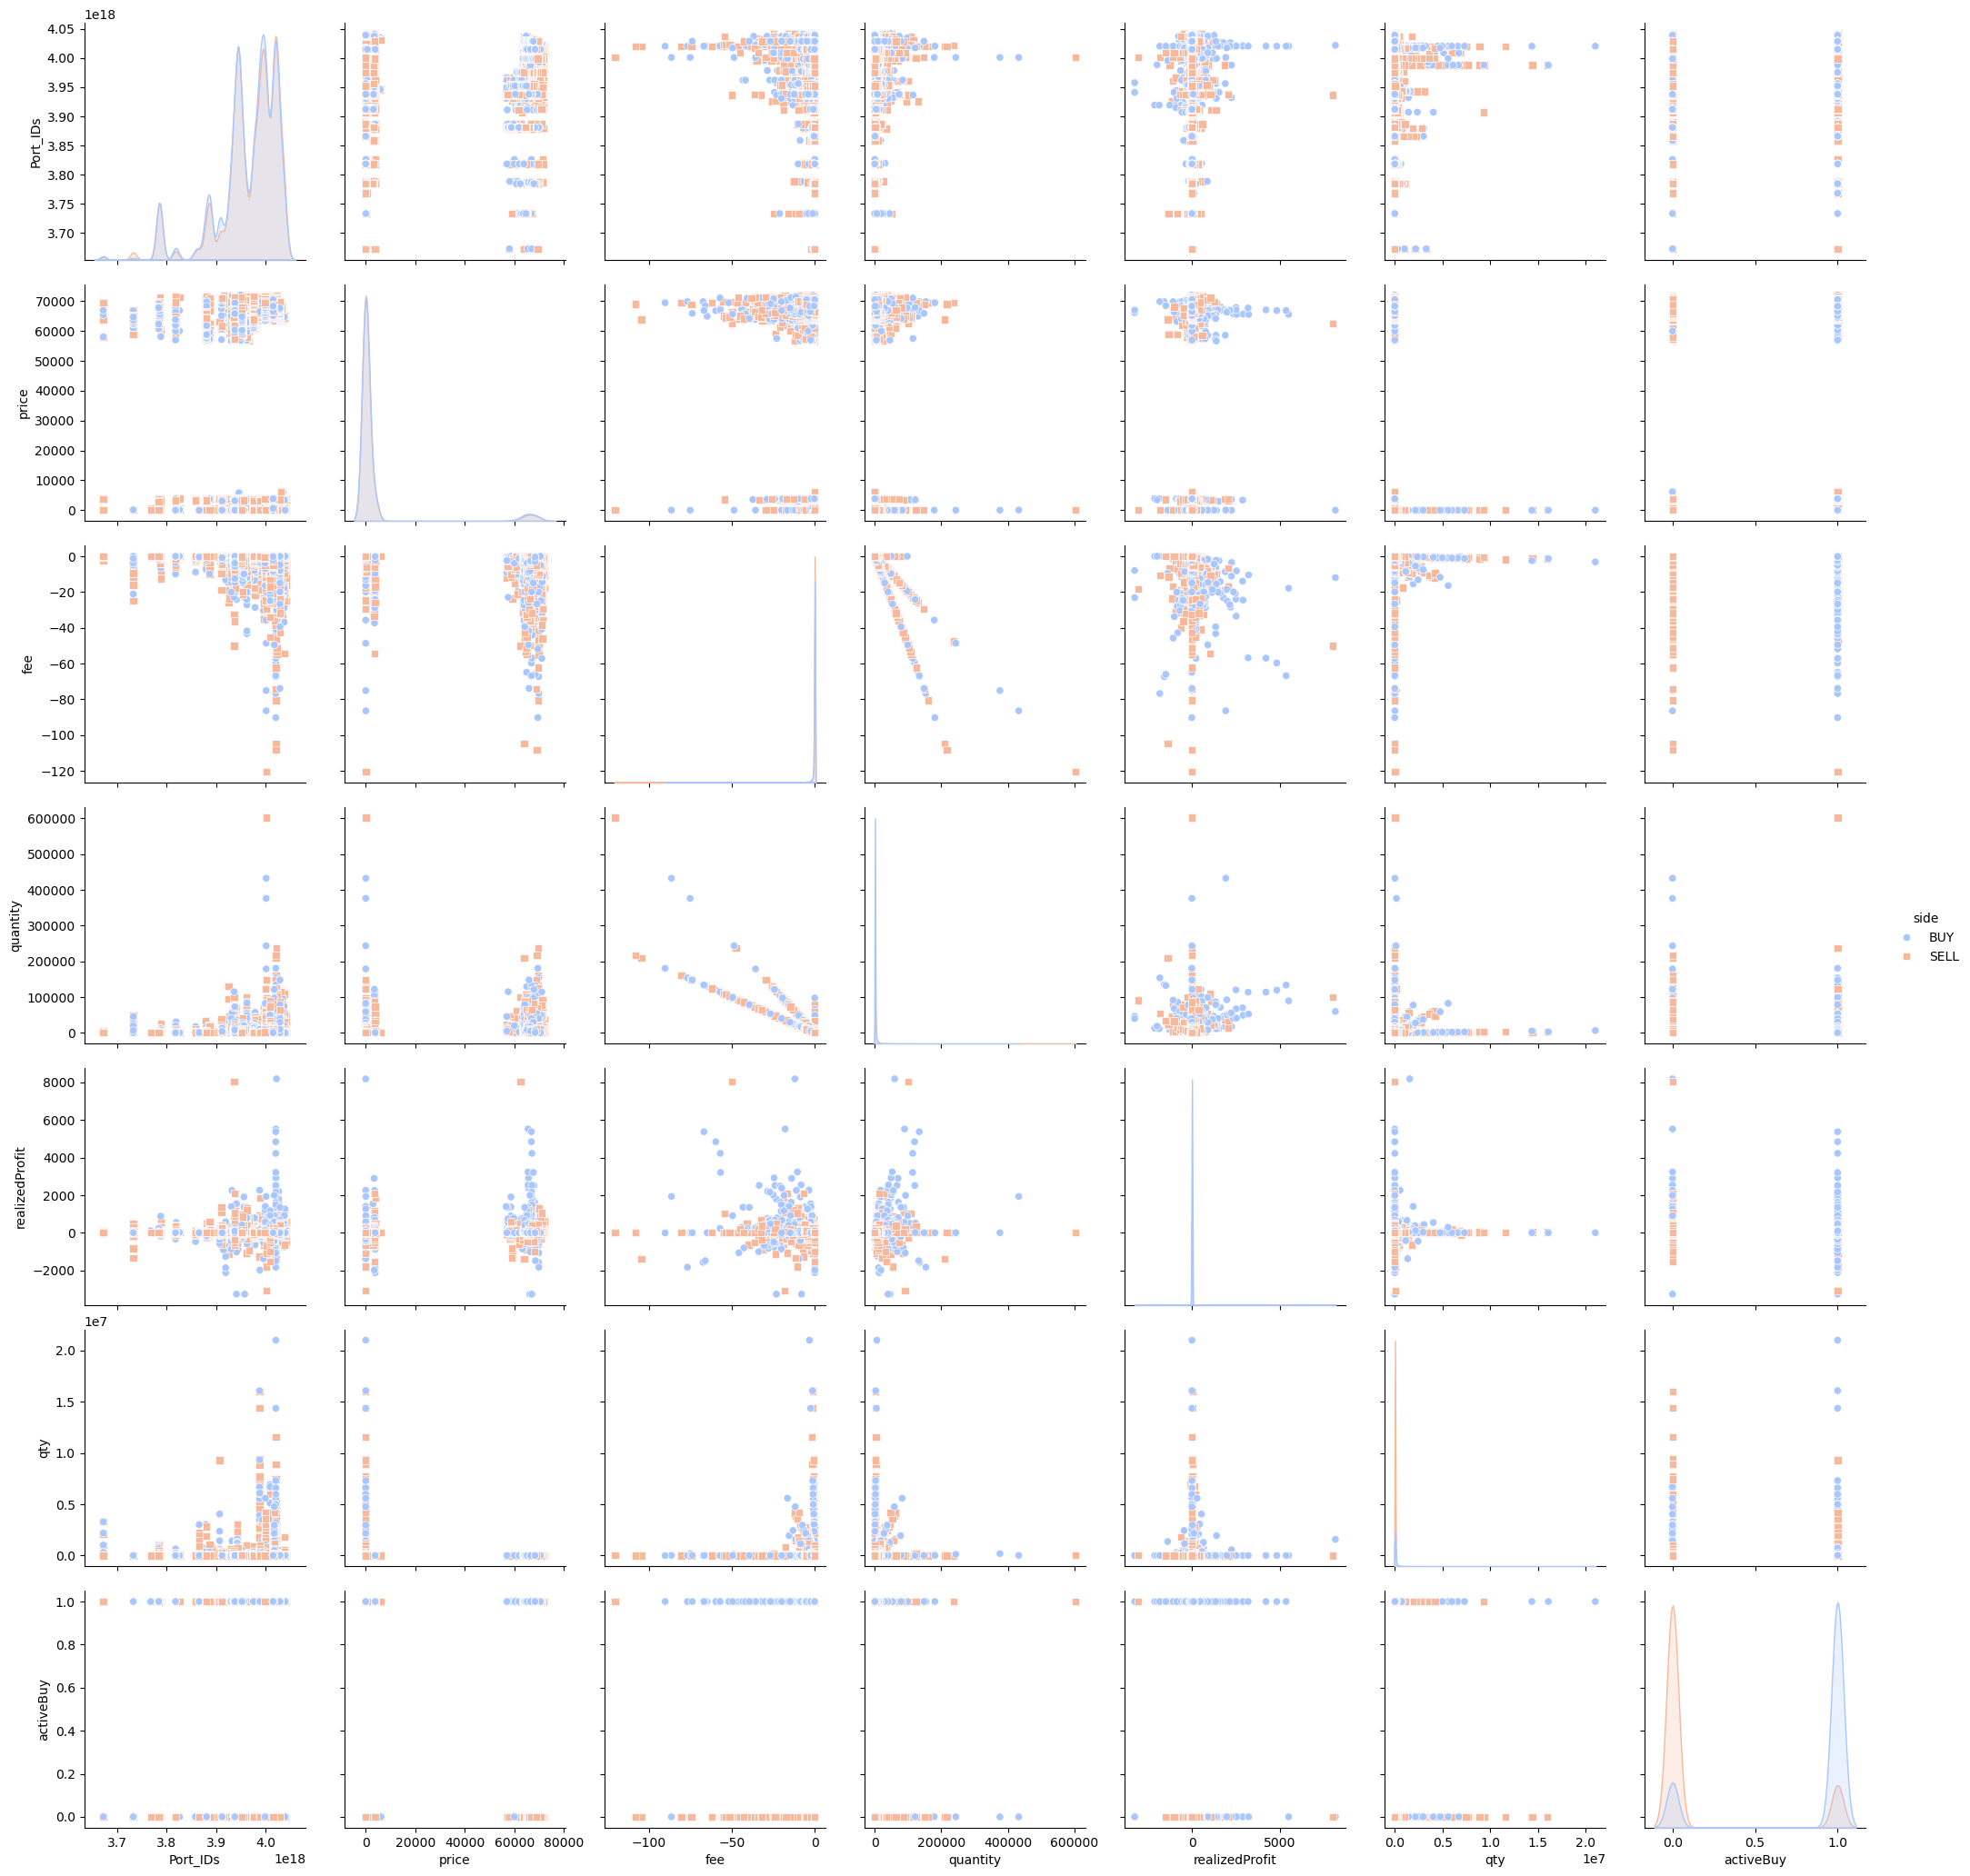

In [99]:
sns.pairplot(df_final, hue="side", palette="coolwarm", markers=["o", "s"], height=3)

In [100]:
df_final["positionSide"].unique()

array(['LONG', 'SHORT', 'BOTH'], dtype=object)

In [60]:
print(df_final["side"].unique())
print(df_final["positionSide"].unique())

['BUY' 'SELL']
['LONG' 'SHORT' 'BOTH']


In [65]:
# Ensure all values are uppercase and stripped of spaces
df_final["side"] = df_final["side"].str.strip().str.upper()
df_final["positionSide"] = df_final["positionSide"].str.strip().str.upper()

In [ ]:
# Create position_type column conditions  based on the  side & positionSide
conditions = [
    (df_final["side"] == "BUY") & (df_final["positionSide"] == "LONG"),
    (df_final["side"] == "SELL") & (df_final["positionSide"] == "LONG"),
    (df_final["side"] == "BUY") & (df_final["positionSide"] == "SHORT"),
    (df_final["side"] == "SELL") & (df_final["positionSide"] == "SHORT"),
]

In [ ]:
# Create a list of the values we want to assign for each condition
choices = ["long_open", "long_close", "short_open", "short_close"]

# Assign the values based on the conditions
df_final["position_type"] = np.select(conditions, choices, default=None)

In [69]:
df_final["position_type"].value_counts()

position_type
both_position    78585
short_close      36046
short_open       34992
long_open        31131
long_close       30523
Name: count, dtype: int64

In [75]:
df_final[df_final["position_type"].notna()].sort_values(["Port_IDs", "time"]).head()

,Port_IDs,time,symbol,side,price,fee,feeAsset,quantity,quantityAsset,realizedProfit,realizedProfitAsset,baseAsset,qty,positionSide,activeBuy,position_type
117572,3672754654734989568,2024-04-22 19:33:57,ONTUSDT,SELL,0.4799,-0.021212,USDT,106.05790,USDT,0.0000,USDT,ONT,221.0,SHORT,True,short_close
117571,3672754654734989568,2024-04-22 20:00:15,ONTUSDT,BUY,0.4780,-0.052819,USDT,105.63800,USDT,0.4199,USDT,ONT,221.0,SHORT,True,short_open
117569,3672754654734989568,2024-04-23 00:22:45,ONTUSDT,SELL,0.4864,-0.024106,USDT,120.52992,USDT,0.0000,USDT,ONT,247.8,SHORT,True,short_close
117570,3672754654734989568,2024-04-23 00:22:45,ONTUSDT,SELL,0.4864,-0.003619,USDT,18.09408,USDT,0.0000,USDT,ONT,37.2,SHORT,True,short_close
117568,3672754654734989568,2024-04-23 00:30:12,ONTUSDT,SELL,0.5022,-0.019084,USDT,95.41800,USDT,0.0000,USDT,ONT,190.0,SHORT,True,short_close


In [358]:
if "time" in df_final.columns:
    df_final["datetime"] = pd.to_datetime(
        df_final["time"]
    )  # Convert to datetime format
    df_final["date"] = df_final["datetime"].dt.date  # Extract date
    df_final["time"] = df_final["datetime"].dt.time  # Extract time
else:
    print("Error: 'datetime' column not found!")

In [359]:
df_final.head()

,time,symbol,side,price,fee,feeAsset,quantity,quantityAsset,realizedProfit,realizedProfitAsset,baseAsset,qty,positionSide,activeBuy,datetime,date
0,16:07:36,SOLUSDT,BUY,132.53700,-0.994027,USDT,1988.05500,USDT,0.0,USDT,SOL,15.0,LONG,True,2024-06-20 16:07:36,2024-06-20
1,16:06:58,DOGEUSDT,BUY,0.12182,-0.279796,USDT,1398.98088,USDT,0.0,USDT,DOGE,11484.0,LONG,False,2024-06-20 16:06:58,2024-06-20
2,16:06:58,DOGEUSDT,BUY,0.12182,-0.039494,USDT,197.47022,USDT,0.0,USDT,DOGE,1621.0,LONG,False,2024-06-20 16:06:58,2024-06-20
3,16:06:56,DOGEUSDT,BUY,0.12182,-0.008284,USDT,16.56752,USDT,0.0,USDT,DOGE,136.0,LONG,True,2024-06-20 16:06:56,2024-06-20
4,16:06:56,DOGEUSDT,BUY,0.12182,-0.046109,USDT,92.21774,USDT,0.0,USDT,DOGE,757.0,LONG,True,2024-06-20 16:06:56,2024-06-20


In [360]:
df_final.columns

Index(['time', 'symbol', 'side', 'price', 'fee', 'feeAsset', 'quantity',
       'quantityAsset', 'realizedProfit', 'realizedProfitAsset', 'baseAsset',
       'qty', 'positionSide', 'activeBuy', 'datetime', 'date'],
      dtype='object')

In [361]:
columns = [
    "time",
    "date",
    "symbol",
    "side",
    "price",
    "fee",
    "feeAsset",
    "quantity",
    "quantityAsset",
    "realizedProfit",
    "realizedProfitAsset",
    "baseAsset",
    "qty",
    "positionSide",
    "activeBuy",
]

In [362]:
df_final = df_final[columns]

In [363]:
df_final.head()

,time,date,symbol,side,price,fee,feeAsset,quantity,quantityAsset,realizedProfit,realizedProfitAsset,baseAsset,qty,positionSide,activeBuy
0,16:07:36,2024-06-20,SOLUSDT,BUY,132.53700,-0.994027,USDT,1988.05500,USDT,0.0,USDT,SOL,15.0,LONG,True
1,16:06:58,2024-06-20,DOGEUSDT,BUY,0.12182,-0.279796,USDT,1398.98088,USDT,0.0,USDT,DOGE,11484.0,LONG,False
2,16:06:58,2024-06-20,DOGEUSDT,BUY,0.12182,-0.039494,USDT,197.47022,USDT,0.0,USDT,DOGE,1621.0,LONG,False
3,16:06:56,2024-06-20,DOGEUSDT,BUY,0.12182,-0.008284,USDT,16.56752,USDT,0.0,USDT,DOGE,136.0,LONG,True
4,16:06:56,2024-06-20,DOGEUSDT,BUY,0.12182,-0.046109,USDT,92.21774,USDT,0.0,USDT,DOGE,757.0,LONG,True


In [374]:
df_final["side"].value_counts()

side
BUY     107292
SELL    103985
Name: count, dtype: int64

In [380]:
print(df.shape)  # Check number of rows & columns
print(df.columns)  # Check column names
print(df_final.shape)  # Check data types
print(df_final.columns)  # Check for missing values

(149, 2)
Index(['Port_IDs', 'Trade_History'], dtype='object')
(211277, 15)
Index(['time', 'date', 'symbol', 'side', 'price', 'fee', 'feeAsset',
       'quantity', 'quantityAsset', 'realizedProfit', 'realizedProfitAsset',
       'baseAsset', 'qty', 'positionSide', 'activeBuy'],
      dtype='object')


In [381]:
df.head()

,Port_IDs,Trade_History
0,3925368433214965504,"[{'time': 1718899656000, 'symbol': 'SOLUSDT', ..."
1,4002413037164645377,"[{'time': 1718980078000, 'symbol': 'NEARUSDT',..."
2,3923766029921022977,"[{'time': 1718677164000, 'symbol': 'ETHUSDT', ..."
3,3994879592543698688,"[{'time': 1718678214000, 'symbol': 'ETHUSDT', ..."
4,3926423286576838657,"[{'time': 1718979615000, 'symbol': 'ETHUSDT', ..."
